# Setup

### Imports

In [1]:
import time
import os
from dataclasses import dataclass
import pandas as pd
import numpy as np
import torch
from matplotlib import pyplot as plt
import scipy.spatial.distance
import transformers
from datasets import load_dataset

import lib.sst as sst
import lib.utils as utils

### Configuration

In [2]:
transformers.utils.logging.set_verbosity_error()
utils.fix_random_seeds()

cpu_device = 'cpu'
gpu_device = 'cuda' if torch.cuda.is_available() else 'cpu'

params = {
    'text.usetex': True,
    'text.latex.preamble': r"\usepackage{lmodern}",
    'font.size': 11,
    'font.family': 'lmodern',
    'figure.figsize': (6, 6),
    'figure.dpi': 100,
    'savefig.dpi': 1000,}

plt.rcParams.update(params)


### Load Datasets

In [3]:
dyna_r1 = load_dataset("dynabench/dynasent", "dynabench.dynasent.r1.all")
dyna_r1_dev = dyna_r1['validation'].to_pandas()
dyna_r1_test = dyna_r1['test'].to_pandas()
dyna_r2 = load_dataset("dynabench/dynasent", "dynabench.dynasent.r2.all")
dyna_r2_train = dyna_r2['train'].to_pandas()
dyna_r2_dev = dyna_r2['validation'].to_pandas()
dyna_r2_test = dyna_r2['test'].to_pandas()
print(f'dyna_r1_dev.shape: {dyna_r1_dev.shape}')
print(f'dyna_r2_dev.shape: {dyna_r2_dev.shape}')

DEV_DATAFRAMES = [dyna_r1_dev, dyna_r2_dev]
# TEST_DATAFRAMES = [dyna_r1_test, dyna_r2_test]

print(f'Dev dataset length:  {sum([len(df) for df in DEV_DATAFRAMES])}')
# print(f'Test dataset length: {sum([len(df) for df in TEST_DATAFRAMES])}')

Reusing dataset dynabench_dyna_sent (C:\Users\Gabe\.cache\huggingface\datasets\dynabench___dynabench_dyna_sent\dynabench.dynasent.r1.all\1.1.0\ab89971d9ae1aacc59ed44d6855bf0e89167417257e2c2666f38e532148f2967)
100%|██████████| 3/3 [00:00<00:00, 374.69it/s]
Reusing dataset dynabench_dyna_sent (C:\Users\Gabe\.cache\huggingface\datasets\dynabench___dynabench_dyna_sent\dynabench.dynasent.r2.all\1.1.0\ab89971d9ae1aacc59ed44d6855bf0e89167417257e2c2666f38e532148f2967)
100%|██████████| 3/3 [00:00<00:00, 499.54it/s]

dyna_r1_dev.shape: (3600, 12)
dyna_r2_dev.shape: (720, 12)
Dev dataset length:  4320


### Load Saved Experiments

In [4]:
experiment_file_names = [
    'experiment_RoBERTa-Base (Baseline).pt',
    'experiment_RoBERTa-Base (AAN).pt',
    'experiment_DynaSent-M1 (Baseline).pt',
    'experiment_DynaSent-M1 (AAN).pt',
]

colors = ['orangered', 'orangered', 'dodgerblue', 'dodgerblue']
linestyles = [(0, (5, 1)), 'solid'] * 2
hatches = ['//', None] * 2
    
experiments = []
for file_name, color, linestyle, hatch in zip(experiment_file_names, colors, linestyles, hatches):
    try:
        experiment = torch.load(os.path.join('models', file_name))
    except FileNotFoundError as error:
        print(f'Could not load trained experiment file {file_name}! Did you run train_and_save_models.ipynb first?')
        raise error

    # Force CPU to not run out of GPU memory with all models loaded
    experiment['model'].device = cpu_device
    experiment['model'].model.to(cpu_device)
    experiment['model'].model.eval()
    experiment['graph_color'] = color
    experiment['graph_linestyle'] = linestyle
    experiment['graph_hatch'] = hatch
    experiments.append(experiment)
    print(f'Loaded experiment for model {experiment["model"]}')

Loaded experiment for model RoBERTa-Base (Baseline)
Loaded experiment for model RoBERTa-Base (AAN)
Loaded experiment for model DynaSent-M1 (Baseline)
Loaded experiment for model DynaSent-M1 (AAN)


# 1. Quantitative Performance Evaluation

### Training Metrics

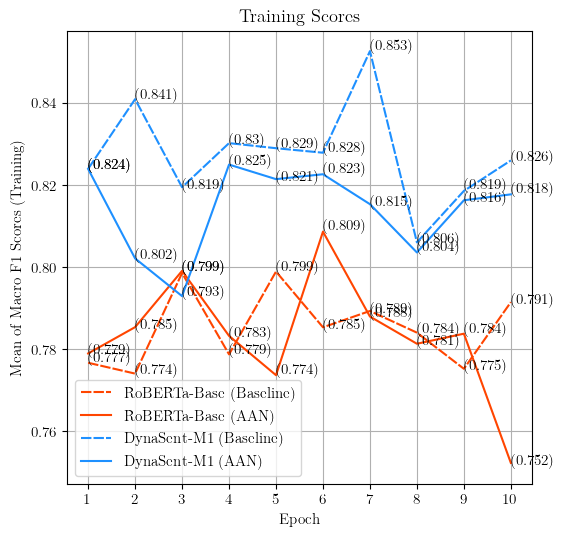

In [5]:
# Plot validation scores computed during training on held-out portions of the train set
for experiment in experiments:
    scores = experiment['model'].validation_scores
    epochs = list(range(1, len(scores) + 1))
    plt.plot(epochs, scores, label=f'{experiment["model"]}',
        color=experiment['graph_color'], linestyle=experiment['graph_linestyle'])
    # Data labels
    rounded_scores = [round(score, 3) for score in scores]
    for xy in zip(epochs, rounded_scores):
        plt.annotate('(%s)' % xy[1], xy=xy, textcoords='data')

plt.ylabel('Mean of Macro F1 Scores (Training)')
plt.xlabel('Epoch')
plt.title('Training Scores')
plt.grid()
plt.xticks(epochs)
plt.legend()

plt.savefig(os.path.join('plots', 'Training Scores.png'))

plt.show()


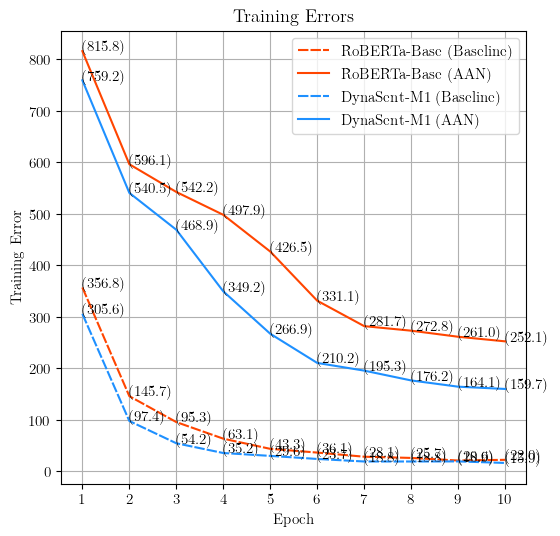

In [6]:
# Plot training losses
for experiment in experiments:
    errors = experiment['model'].training_errors
    epochs = list(range(1, len(errors) + 1))
    plt.plot(epochs, errors, label=f'{experiment["model"]}',
        color=experiment['graph_color'], linestyle=experiment['graph_linestyle'])
    # Data labels
    rounded_errors = [round(error, 1) for error in errors]
    for xy in zip(epochs, rounded_errors):
        plt.annotate('(%s)' % xy[1], xy=xy, textcoords='data')

plt.ylabel('Training Error')
plt.xlabel('Epoch')
plt.title('Training Errors')
plt.grid()
plt.xticks(epochs)
plt.legend()

plt.savefig(os.path.join('plots', 'Training Errors.png'))

plt.show()


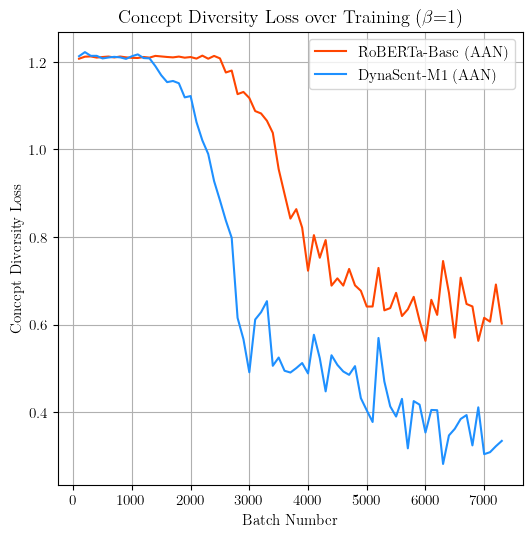

In [7]:
# Plot just the diversity loss component for the AAN models over training
for experiment in [experiments[1], experiments[3]]:
    diversity_penalties = experiment['model'].loss.diversity_penalties
    batches = list(range(1, len(diversity_penalties) + 1))
    batches = [batch * 100 for batch in batches]
    plt.plot(batches, diversity_penalties, label=f'{experiment["model"]}',
        color=experiment['graph_color'], linestyle=experiment['graph_linestyle'])

plt.ylabel('Concept Diversity Loss')
plt.xlabel('Batch Number')
plt.title('Concept Diversity Loss over Training ($\\beta$=1)')
plt.grid()
# plt.xticks(batches)
plt.legend()

plt.savefig(os.path.join('plots', 'Training Errors Diversity.png'))

plt.show()


### Dev Set Evaluation

In [8]:
def evaluate_dataset(assess_df, title, score_func=utils.safe_macro_f1):
    # Build the dataset for assessment
    assess = sst.build_dataset(
        assess_df,
        experiments[0]['phi'],
        vectorize=False)

    # Run the model and assess the predictions
    scores = []
    all_preds = []
    for experiment in experiments:
        model = experiment['model']
        print(f'Evaluating {model}' , end =': ')
        
        # Move to GPU for faster processing
        model.device = gpu_device
        model.model.to(gpu_device)
        preds = model.predict(assess['X'])
        model.model.to(cpu_device)
        model.device = cpu_device
        
        score = score_func(assess['y'], preds)
        scores.append(score)
        all_preds.append(preds)
        print(score)

    for experiment, score in zip(experiments, scores):
        model_name = str(experiment['model'])
        model_name = '\n('.join(model_name.split(' ('))  # Split to new lines
        plt.bar(model_name, score, color=experiment['graph_color'], hatch=experiment['graph_hatch'])
    plt.ylabel('Mean of Macro F1 Scores (Evaluation)')
    plt.xlabel('Model')
    plt.title(title)

    plt.savefig(os.path.join('plots', f'{title}.png'))

    return scores, all_preds, assess['y']
    

Evaluating RoBERTa-Base (Baseline): 0.6820114090464182
Evaluating RoBERTa-Base (AAN): 0.6729728043244415
Evaluating DynaSent-M1 (Baseline): 0.7308669129330049
Evaluating DynaSent-M1 (AAN): 0.7046678324424369


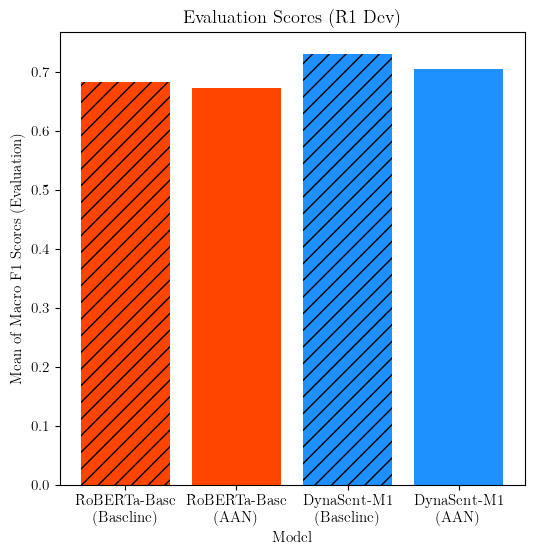

In [9]:
# Dynasent Round 1 Dev
dyna_r1_dev_scores, dyna_r1_dev_preds, dyna_r1_dev_gold = evaluate_dataset(dyna_r1_dev, 'Evaluation Scores (R1 Dev)')

# This cell takes about 1 minutes on an RTX 2070

Evaluating RoBERTa-Base (Baseline): 0.6608728685785229
Evaluating RoBERTa-Base (AAN): 0.6303124197387414
Evaluating DynaSent-M1 (Baseline): 0.6574574552795042
Evaluating DynaSent-M1 (AAN): 0.6889906415344275


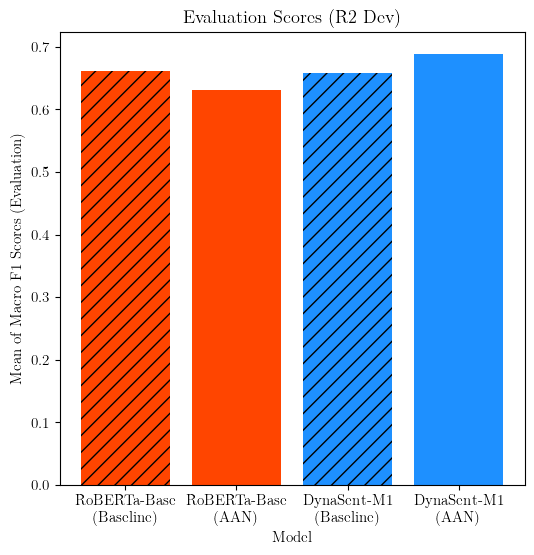

In [10]:
# Dynasent Round 2 Dev
dyna_r2_dev_scores, dyna_r2_dev_preds, dyna_r2_dev_gold = evaluate_dataset(dyna_r2_dev, 'Evaluation Scores (R2 Dev)')

### Test Set Evaluation
Evaluate on test sets once at the end of model development.

Evaluating RoBERTa-Base (Baseline): 0.6951926195968343
Evaluating RoBERTa-Base (AAN): 0.6919810506423744
Evaluating DynaSent-M1 (Baseline): 0.7398151248380224
Evaluating DynaSent-M1 (AAN): 0.7097710269500883


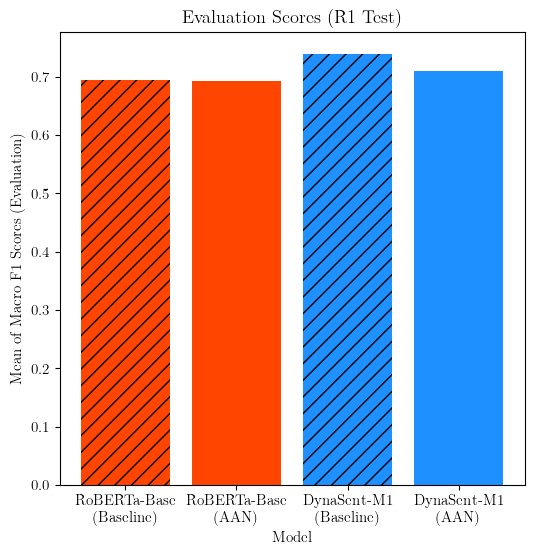

In [11]:
# Dynasent Round 1 Test
dyna_r1_test_scores, dyna_r1_test_preds, dyna_r1_test_gold = evaluate_dataset(dyna_r1_test, 'Evaluation Scores (R1 Test)')

# This cell takes about 1.2 minutes on an RTX 2070

Evaluating RoBERTa-Base (Baseline): 0.683222746498691
Evaluating RoBERTa-Base (AAN): 0.645197090626054
Evaluating DynaSent-M1 (Baseline): 0.6621150800558667
Evaluating DynaSent-M1 (AAN): 0.7219678503338586


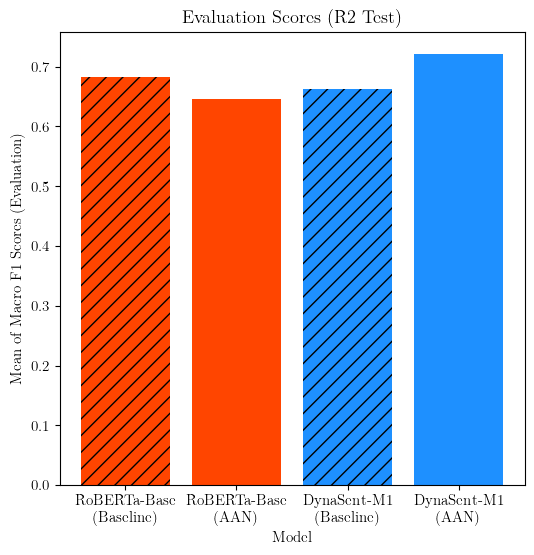

In [12]:
# Dynasent Round 2 Test
dyna_r2_test_scores, dyna_r2_test_preds, dyna_r2_test_gold = evaluate_dataset(dyna_r2_test, 'Evaluation Scores (R2 Test)')

### McNemar's Test of Statistical Significance

We can use [McNemar's Test](https://en.wikipedia.org/wiki/McNemar%27s_test) to evaluate whether the predictions of two different models on the same data set are statistically significant. If they aren't statistically significant (e.g. p > 0.01), then we can conclude that the models don't perform differently on that dataset.

In [13]:
# Use McNemar's Test to evaluate whether classifier outputs are significantly different
def calculate_significance(test_name, gold_labels, model_1_preds, model_2_preds):
    p_threshold = 0.01
    _, significance = utils.mcnemar(gold_labels, model_1_preds, model_2_preds)
    is_significant_text = 'NOT significant' if significance > p_threshold else 'SIGNIFICANT'
    print(f'p={significance:.3g} ({is_significant_text}) for test {test_name}')
    return significance

significance_tests = [
    ('Dyna R1 Dev', None, None, None), # line break
    ('Dyna R1 Dev: RoBERTa Baseline vs RoBERTa AAN', dyna_r1_dev_gold, dyna_r1_dev_preds[0], dyna_r1_dev_preds[1]),
    ('Dyna R1 Dev: DynaSent-M1 Baseline vs DynaSent-M1 AAN', dyna_r1_dev_gold, dyna_r1_dev_preds[2], dyna_r1_dev_preds[3]),
    ('Dyna R1 Dev: RoBERTa Baseline vs DynaSent-M1 Baseline', dyna_r1_dev_gold, dyna_r1_dev_preds[0], dyna_r1_dev_preds[2]),
    ('Dyna R1 Dev: RoBERTa AAN vs DynaSent-M1 AAN', dyna_r1_dev_gold, dyna_r1_dev_preds[1], dyna_r1_dev_preds[3]),
    ('\nDyna R2 Dev', None, None, None), # line break
    ('Dyna R2 Dev: RoBERTa Baseline vs RoBERTa AAN', dyna_r2_dev_gold, dyna_r2_dev_preds[0], dyna_r2_dev_preds[1]),
    ('Dyna R2 Dev: DynaSent-M1 Baseline vs DynaSent-M1 AAN', dyna_r2_dev_gold, dyna_r2_dev_preds[2], dyna_r2_dev_preds[3]),
    ('Dyna R2 Dev: RoBERTa Baseline vs DynaSent-M1 Baseline', dyna_r2_dev_gold, dyna_r2_dev_preds[0], dyna_r2_dev_preds[2]),
    ('Dyna R2 Dev: RoBERTa AAN vs DynaSent-M1 AAN', dyna_r2_dev_gold, dyna_r2_dev_preds[1], dyna_r2_dev_preds[3]),
    ('\nDyna R1 Test', None, None, None), # line break
    ('Dyna R1 Test: RoBERTa Baseline vs RoBERTa AAN', dyna_r1_test_gold, dyna_r1_test_preds[0], dyna_r1_test_preds[1]),
    ('Dyna R1 Test: DynaSent-M1 Baseline vs DynaSent-M1 AAN', dyna_r1_test_gold, dyna_r1_test_preds[2], dyna_r1_test_preds[3]),
    ('Dyna R1 Test: RoBERTa Baseline vs DynaSent-M1 Baseline', dyna_r1_test_gold, dyna_r1_test_preds[0], dyna_r1_test_preds[2]),
    ('Dyna R1 Test: RoBERTa AAN vs DynaSent-M1 AAN', dyna_r1_test_gold, dyna_r1_test_preds[1], dyna_r1_test_preds[3]),
    ('\nDyna R2 Test', None, None, None), # line break
    ('Dyna R2 Test: RoBERTa Baseline vs RoBERTa AAN', dyna_r2_test_gold, dyna_r2_test_preds[0], dyna_r2_test_preds[1]),
    ('Dyna R2 Test: DynaSent-M1 Baseline vs DynaSent-M1 AAN', dyna_r2_test_gold, dyna_r2_test_preds[2], dyna_r2_test_preds[3]),
    ('Dyna R2 Test: RoBERTa Baseline vs DynaSent-M1 Baseline', dyna_r2_test_gold, dyna_r2_test_preds[0], dyna_r2_test_preds[2]),
    ('Dyna R2 Test: RoBERTa AAN vs DynaSent-M1 AAN', dyna_r2_test_gold, dyna_r2_test_preds[1], dyna_r2_test_preds[3]),
]

for test_name, gold_labels, model_1_preds, model_2_preds in significance_tests:
    if gold_labels == None:
        print(test_name)
    else:
        calculate_significance(test_name, gold_labels, model_1_preds, model_2_preds)

Dyna R1 Dev
p=0.0881 (NOT significant) for test Dyna R1 Dev: RoBERTa Baseline vs RoBERTa AAN
p=0.000427 (SIGNIFICANT) for test Dyna R1 Dev: DynaSent-M1 Baseline vs DynaSent-M1 AAN
p=3.72e-10 (SIGNIFICANT) for test Dyna R1 Dev: RoBERTa Baseline vs DynaSent-M1 Baseline
p=2.28e-05 (SIGNIFICANT) for test Dyna R1 Dev: RoBERTa AAN vs DynaSent-M1 AAN

Dyna R2 Dev
p=0.192 (NOT significant) for test Dyna R2 Dev: RoBERTa Baseline vs RoBERTa AAN
p=0.0738 (NOT significant) for test Dyna R2 Dev: DynaSent-M1 Baseline vs DynaSent-M1 AAN
p=0.863 (NOT significant) for test Dyna R2 Dev: RoBERTa Baseline vs DynaSent-M1 Baseline
p=0.00932 (SIGNIFICANT) for test Dyna R2 Dev: RoBERTa AAN vs DynaSent-M1 AAN

Dyna R1 Test
p=0.384 (NOT significant) for test Dyna R1 Test: RoBERTa Baseline vs RoBERTa AAN
p=3.9e-05 (SIGNIFICANT) for test Dyna R1 Test: DynaSent-M1 Baseline vs DynaSent-M1 AAN
p=1.63e-08 (SIGNIFICANT) for test Dyna R1 Test: RoBERTa Baseline vs DynaSent-M1 Baseline
p=0.0109 (NOT significant) for test

# Concept-Based Explanations

Our AAN-based models are able to produce concept-based explanations of their classification decisions.

We choose to run all of our explanations on the DynaSent Model 1 AAN model, but these could also be evaluated on the RoBERTA-Base AAN model or other AAN models.

### Precomputation

In [14]:
# Use the DynaSent Model 1 AAN
desired_model_name = 'DynaSent-M1 (AAN)' # 'RoBERTa-Base (AAN)'
concept_explanation_model = [experiment['model'] for experiment in experiments if str(experiment['model']) == desired_model_name][0]
concept_explanation_model.model.to(gpu_device)
concept_explanation_model.device = gpu_device

In [15]:
# Choose a dictionary of keywords to use as inputs

# Import a small (25k) English dictionary
# https://github.com/dolph/dictionary
with open('data/popular.txt') as word_file:
    concept_keyword_list = np.array(word_file.read().split())

# Debug choose only a random 1000
# concept_keyword_list = concept_keyword_list[np.random.choice(len(concept_keyword_list), size=1000, replace=False)]

# Alternative: Use RoBERTa's tokens (50k tokens)
# tokenizer = concept_explanation_model.roberta_tokenizer
# concept_keyword_list: list[str] = list(tokenizer.vocab.keys())

num_concept_keywords = len(concept_keyword_list)
print(f'Loaded {num_concept_keywords} keywords. Examples:')
print(concept_keyword_list[np.random.choice(num_concept_keywords, size=6, replace=False)])

Loaded 25322 keywords. Examples:
['cram' 'legislature' 'untoward' 'waves' 'hurray' 'decked']


In [16]:
# Precompute (or load) the abstraction-attention context representations (10x768) for each keyword.
# We will compare these representations to find keywords associated with concepts.
from lib.sentiment_models import NUM_CONCEPTS, HIDDEN_DIM, BATCH_SIZE

FORCE_COMPUTE_REPRESENTATIONS = True

keywords_representations_save_path = os.path.join('data', 'keywords_representations.npy')
must_precompute_representations = not os.path.exists(keywords_representations_save_path) or FORCE_COMPUTE_REPRESENTATIONS
if not must_precompute_representations:
    print(f'Loading representations for {num_concept_keywords} keywords...')
    keywords_representations = np.load(keywords_representations_save_path)
    print(f'Loaded representations for {len(keywords_representations)} keywords.')

    if len(keywords_representations) != num_concept_keywords:
        print(f'Whoops! Loaded {len(keywords_representations)} keyword representations, but was expecting {num_concept_keywords}. Regenerating them now.')
        must_precompute_representations = True

if must_precompute_representations:
    print(f'Precomputing representations for {num_concept_keywords} keywords...')

    keywords_representations = np.zeros((num_concept_keywords, NUM_CONCEPTS, HIDDEN_DIM))

    num_batches = (num_concept_keywords / BATCH_SIZE) + 1

    start_time = time.time()
    for batch_i in range(0, num_concept_keywords, BATCH_SIZE):
        # Forward the input through the model so it stores the attention contexts
        batch_inputs = concept_keyword_list[batch_i:batch_i+BATCH_SIZE].tolist()
        concept_explanation_model.predict(batch_inputs)

        fraction_complete = (batch_i + 1) / num_concept_keywords
        minutes_since_start = (time.time() - start_time) / 60
        minutes_expected = minutes_since_start / fraction_complete * (1 - fraction_complete)
        message = f'Keyword {batch_i + 1}/{num_concept_keywords} ' \
            f'({round(fraction_complete * 100, 2)}%). ' \
            f'{round(minutes_since_start, 2)} min elapsed, {round(minutes_expected, 2)} min remaining. '
        utils.progress_bar(message)

        # Capture the saved attention contexts
        ctx_abs = concept_explanation_model.pooling_module.ctx_abs.detach().cpu()
        keywords_representations[
            batch_i:min(batch_i + BATCH_SIZE, num_concept_keywords), :, :] = ctx_abs

    np.save(keywords_representations_save_path, keywords_representations)

Precomputing representations for 25322 keywords...


### Explanation Generation

In [60]:
@dataclass
class ConceptExplanation:
    """Represents an explanation of a single sentence and facilitates easy printing."""
    sentence: str # The input sentence
    prediction: str # The sentiment prediction
    scores: list[float] # The scores for each of the K concepts
    keywords: list[list[str]] # The keywords for each of the K concepts

    def get_explanation_string(self, sort_by_scores=True, output_latex=True):
        output = f'Prediction: {str.upper(self.prediction)}\nSentence: "{self.sentence}"\n'
        output += f'{"Concept":^8}{"Score":^10}{"Keywords":<20}\n'
        output += '='*100 + '\n'
        if output_latex:
            output = ('\\scriptsize\n\\begin{tabular}{|c|c|p{4.5cm}|}\n'
                    '\\hline\n'
                    f'\\multicolumn{{3}}{{|c|}}{{\\textbf{{Prediction}}: {str.upper(self.prediction)}}} \\\\\n'
                    f'\\multicolumn{{3}}{{|p{{6.5cm}}|}}{{\\textbf{{Sentence}}: {self.sentence}}} \\\\\n'
                    '\\hline\n'
                    '\\textbf{CID} & \\textbf{Score} & \\textbf{Keywords} \\\\\n'
                    '\\hline\n')

        # Sorting by scores
        indices = range(NUM_CONCEPTS)
        if sort_by_scores:
            indices = np.array(self.scores).argsort()[::-1]

        for id in indices:
            score = self.scores[id]
            keyword_list = self.keywords[id]
            if output_latex:
                output += f'{id}&{score:.3f}&{", ".join(keyword_list)} \\\\\n\\hline\n'
            else:
                output += f'{id:^8} {score:.5f}  {", ".join(keyword_list):<20}\n'
        
        if output_latex:
            output += '\\end{tabular}\n\\normalsize\n'

        return output

    def __repr__(self):
        return self.get_explanation_string()


def get_concept_explanation(sentence, num_keywords_per_concept=6, distance_metric=scipy.spatial.distance.cosine):
    """Gets the scores and keywords for the K=10 concepts for a given input sentence."""
    # Forward the input through the model
    prediction = concept_explanation_model.predict([sentence])[0]

    # Capture the saved attention weights
    ctx_abs = concept_explanation_model.pooling_module.ctx_abs.detach().cpu()
    attn_agg = concept_explanation_model.pooling_module.attn_agg.detach().cpu()

    # Get the scores from the aggregation-attention weights
    scores = attn_agg.squeeze().numpy().tolist()

    # Compute the cosine distance between this sentence's abs-attention context representations
    # and the precomputed keyword representations (each are of size NUM_CONCEPTS x HIDDEN_DIM).
    distances = np.zeros((num_concept_keywords, NUM_CONCEPTS))
    for keyword_i in range(num_concept_keywords):
        for concept_i in range(NUM_CONCEPTS):
            sentence_repr = ctx_abs[:, concept_i, :].squeeze().numpy()
            keyword_repr = keywords_representations[keyword_i, concept_i, :]
            distances[keyword_i, concept_i] = distance_metric(sentence_repr, keyword_repr)

    # Choose to top n most similar keywords to represent each concept (smallest cosine distances)
    keywords = [[]]*NUM_CONCEPTS
    for concept_i in range(NUM_CONCEPTS):
        indices = distances[:, concept_i].argsort()[:num_keywords_per_concept]
        keywords[concept_i] = concept_keyword_list[indices]

    # Wrap it all up in a cozy object
    return ConceptExplanation(sentence, prediction, scores, keywords)

### Example Explanations
Test the explanations with some hand-written and training set example sentences.

In [62]:
print(get_concept_explanation('If they said it would be excellent, then why did the food taste that way?'))

\scriptsize
\begin{tabular}{|c|c|p{4.5cm}|}
\hline
\multicolumn{3}{|c|}{\textbf{Prediction}: NEGATIVE} \\
\multicolumn{3}{|p{6.5cm}|}{\textbf{Sentence}: If they said it would be excellent, then why did the food taste that way?} \\
\hline
\textbf{CID} & \textbf{Score} & \textbf{Keywords} \\
\hline
5&0.222&inconsiderate, talentless, untraceable, incapacitate, disappoints, unimaginative \\
\hline
7&0.181&incapacitate, incompetent, uncooperative, inconsiderate, shoplifters, disappoints \\
\hline
6&0.169&incompetence, incompetent, misdemeanors, murderess, shoplifters, scrutiny \\
\hline
0&0.168&talentless, disappoints, shoplifters, scrutiny, frustrates, flaws \\
\hline
2&0.162&crucifixion, inaccuracies, sourpuss, nausea, incompetence, infuriating \\
\hline
4&0.091&sordid, aargh, incessantly, incapacitate, bogus, disgrace \\
\hline
9&0.004&disgraced, cholinesterase, boredom, interfering, disheartening, irritated \\
\hline
8&0.003&horseshit, souvlaki, bobcat, disinherit, doofus, dummkopf \\
\

In [63]:
print(get_concept_explanation('Customer service is fast!'))

\scriptsize
\begin{tabular}{|c|c|p{4.5cm}|}
\hline
\multicolumn{3}{|c|}{\textbf{Prediction}: POSITIVE} \\
\multicolumn{3}{|p{6.5cm}|}{\textbf{Sentence}: Customer service is fast!} \\
\hline
\textbf{CID} & \textbf{Score} & \textbf{Keywords} \\
\hline
0&0.200&lovesick, vibrating, brilliance, dynamic, flawless, grinning \\
\hline
2&0.151&loved, liked, excels, exceeded, nailed, appreciates \\
\hline
6&0.124&excellent, genius, awesome, profound, phenomena, immense \\
\hline
8&0.124&glamour, pamper, sophistication, glamor, enchantment, cutesy \\
\hline
7&0.123&whirlwind, gorgeous, vivid, stunningly, wicked, triumphs \\
\hline
4&0.101&exceed, blockbusters, awol, miraculous, enthusiasm, thanking \\
\hline
5&0.095&perfecting, addictive, best, perfectly, stylish, perfection \\
\hline
9&0.068&sublime, stunning, excellent, spectacular, trusting, superior \\
\hline
1&0.014&succeeds, magnificent, triumphs, succeeded, excels, hallelujah \\
\hline
3&0.001&seamless, triumphs, magnificent, gorgeous, bre

In [64]:
print(get_concept_explanation('My doctor is a woman.'))

\scriptsize
\begin{tabular}{|c|c|p{4.5cm}|}
\hline
\multicolumn{3}{|c|}{\textbf{Prediction}: NEUTRAL} \\
\multicolumn{3}{|p{6.5cm}|}{\textbf{Sentence}: My doctor is a woman.} \\
\hline
\textbf{CID} & \textbf{Score} & \textbf{Keywords} \\
\hline
0&0.196&floodgates, caboose, gazebo, flapjacks, worshippers, tattoos \\
\hline
5&0.179&chimpanzee, lidocaine, crocodile, hippopotamus, bachelorette, rhinoceros \\
\hline
6&0.176&coconut, wrestler, nocturnal, sixpence, fibre, biochemist \\
\hline
7&0.171&rattlesnake, puppeteer, newlyweds, wrestler, nocturnal, coconut \\
\hline
2&0.146&prednisone, journeyed, sleet, jezebel, rhinoceros, honeysuckle \\
\hline
4&0.056&insignia, disregard, smashes, unquote, relieved, disbelief \\
\hline
9&0.040&cholinesterase, aforementioned, remainder, nocturnal, extraterrestrials, unattached \\
\hline
8&0.022&bobcat, souvlaki, angioplasty, pantyhose, hippopotamus, hayloft \\
\hline
1&0.014&boogeyman, snowballed, unscheduled, inconspicuous, skewed, malfeasance \\
\hl

In [65]:
print(get_concept_explanation('My doctor is a man.'))

\scriptsize
\begin{tabular}{|c|c|p{4.5cm}|}
\hline
\multicolumn{3}{|c|}{\textbf{Prediction}: NEUTRAL} \\
\multicolumn{3}{|p{6.5cm}|}{\textbf{Sentence}: My doctor is a man.} \\
\hline
\textbf{CID} & \textbf{Score} & \textbf{Keywords} \\
\hline
9&0.192&undisclosed, aforementioned, unattached, remainder, nearby, dissident \\
\hline
0&0.188&floodgates, caboose, gazebo, flapjacks, tattoos, worshippers \\
\hline
7&0.151&diabetics, biochemist, closest, mathematician, snowmobile, wrestler \\
\hline
6&0.150&biochemist, snowmobile, mathematician, anesthesiologist, stereotype, venetian \\
\hline
2&0.141&prednisone, journeyed, sleet, jezebel, rhinoceros, bridegroom \\
\hline
5&0.073&puppeteer, hayloft, psychotherapist, evolution, windsurfing, zebra \\
\hline
4&0.064&insignia, smashes, unquote, disregard, relieved, disbelief \\
\hline
8&0.027&bobcat, souvlaki, hippopotamus, braggart, angioplasty, maggot \\
\hline
1&0.013&boogeyman, snowballed, inconspicuous, skewed, malfeasance, unscheduled \\
\hli

In [66]:
print(get_concept_explanation('The egg drop soup was as delicious as the long-forgotten, untouched fruitcake that my mother made for me decades ago!'))

\scriptsize
\begin{tabular}{|c|c|p{4.5cm}|}
\hline
\multicolumn{3}{|c|}{\textbf{Prediction}: NEGATIVE} \\
\multicolumn{3}{|p{6.5cm}|}{\textbf{Sentence}: The egg drop soup was as delicious as the long-forgotten, untouched fruitcake that my mother made for me decades ago!} \\
\hline
\textbf{CID} & \textbf{Score} & \textbf{Keywords} \\
\hline
0&0.247&talentless, shoplifters, disappoints, uncontrollable, frustrates, scrutiny \\
\hline
2&0.214&crucifixion, inaccuracies, sourpuss, nausea, incompetence, opportune \\
\hline
5&0.195&unconscionable, inconsiderate, talentless, inconsolable, claustrophobic, untraceable \\
\hline
7&0.163&misogynistic, motherfuckers, disgrace, infuriates, nausea, exasperating \\
\hline
6&0.104&shoplifters, malfeasance, murderess, incompetence, inconveniencing, misdemeanors \\
\hline
4&0.067&sordid, aargh, unimpressed, incapacitate, revenge, disgrace \\
\hline
8&0.007&horseshit, souvlaki, sarcoidosis, bobcat, angioplasty, sauerkraut \\
\hline
9&0.004&cholinesterase, 

In [67]:
print(get_concept_explanation('The food look really bad, it looked as it was over cooked, to my surprise I was highly mistaken.'))

\scriptsize
\begin{tabular}{|c|c|p{4.5cm}|}
\hline
\multicolumn{3}{|c|}{\textbf{Prediction}: POSITIVE} \\
\multicolumn{3}{|p{6.5cm}|}{\textbf{Sentence}: The food look really bad, it looked as it was over cooked, to my surprise I was highly mistaken.} \\
\hline
\textbf{CID} & \textbf{Score} & \textbf{Keywords} \\
\hline
2&0.265&succeeds, exceedingly, enjoyed, enjoys, mesmerizing, succeeded \\
\hline
0&0.196&intrigues, scintillating, brilliance, flawless, glamorous, vibrating \\
\hline
5&0.179&succeeds, scintillating, unconscionable, exhilarated, exhilaration, penetrating \\
\hline
7&0.155&incapacitated, uplink, disinherit, exceedingly, entertained, succeeded \\
\hline
6&0.129&incapacitate, incapacitated, incompetence, incompetent, incomprehensible, whatchamacallit \\
\hline
4&0.068&succeeds, hallelujah, succeeded, exhilaration, enthralled, succeed \\
\hline
8&0.006&souvlaki, horseshit, sauerkraut, dummkopf, whatchamacallit, sarcoidosis \\
\hline
9&0.002&cholinesterase, eucalyptus, disgr

In [68]:
print(get_concept_explanation('The staff has always been friendly and willing to help with any questions I\'ve had.'))

\scriptsize
\begin{tabular}{|c|c|p{4.5cm}|}
\hline
\multicolumn{3}{|c|}{\textbf{Prediction}: POSITIVE} \\
\multicolumn{3}{|p{6.5cm}|}{\textbf{Sentence}: The staff has always been friendly and willing to help with any questions I've had.} \\
\hline
\textbf{CID} & \textbf{Score} & \textbf{Keywords} \\
\hline
2&0.273&succeeds, exceedingly, enjoys, enjoyed, mesmerizing, enamored \\
\hline
0&0.222&brilliance, scintillating, intrigues, glamorous, vibrating, glamour \\
\hline
5&0.174&scintillating, succeeds, exhilaration, exhilarated, penetrating, gallivanting \\
\hline
7&0.132&exceedingly, succeeded, succeeds, wondrous, intrigue, sophisticated \\
\hline
8&0.089&whatchamacallit, hallelujah, exhilaration, extraordinaire, extravaganza, uplink \\
\hline
6&0.059&whatchamacallit, extraordinaire, mausoleum, enthusiastic, enthusiast, congeniality \\
\hline
4&0.034&hallelujah, succeeds, extravaganza, enthusiasm, enthralled, enthusiastic \\
\hline
9&0.017&shorthanded, disgraced, evangelical, comprehen

# Explaining Errors

We can use our concept-based explanations to try to transparently discover errors and biases in the model.

### Error analysis

We use DataFrames to analyze our model's output and select examples based on certain criteria.

In [69]:
def find_errors(sentences, predictions, gold_labels):
    """Find mistaken predictions.
    Returns
    -------
    pd.DataFrame

    """
    df = pd.DataFrame({
        'raw_examples': sentences,
        'predicted': predictions,
        'gold': gold_labels})
    df['correct'] = df['predicted'] == df['gold']
    return df

In [70]:
# Find errors with the DynaSent-M1 AAN model on the DynaSent Round 2 test set.
aan_analysis = find_errors(dyna_r2_test.sentence, dyna_r2_test_preds[3], dyna_r2_test_gold)

In [71]:
# Examples where the model is correct and the gold label is 'positive' or 'negative'
true_positives = aan_analysis[
    (aan_analysis['correct'] == True)
    &
    (aan_analysis['gold'] == 'positive')
]
true_neutrals = aan_analysis[
    (aan_analysis['correct'] == True)
    &
    (aan_analysis['gold'] == 'neutral')
]
true_negatives = aan_analysis[
    (aan_analysis['correct'] == True)
    &
    (aan_analysis['gold'] == 'negative')
]

# Examples where the model is incorrectly 'positive'/'negative and the gold label is 'negative'/'positive'
# Note these are subsets of all false 'positives'/'negatives' since there is a 'neutral' class.
opposite_positives = aan_analysis[
    (aan_analysis['predicted'] == 'positive')
    &
    (aan_analysis['gold'] == 'negative')
]
opposite_negatives = aan_analysis[
    (aan_analysis['predicted'] == 'negative')
    &
    (aan_analysis['gold'] == 'positive')
]

# Print out the counts and some examples
print(f'{true_positives.shape[0]} True Positives')
for ex in true_positives['raw_examples'].sample(3, random_state=1):
    print(f'"{ex}"')

print(f'\n{true_neutrals.shape[0]} True Neutrals')
for ex in true_neutrals['raw_examples'].sample(3, random_state=1):
    print(f'"{ex}"')

print(f'\n{true_negatives.shape[0]} True Negatives')
for ex in true_negatives['raw_examples'].sample(3, random_state=1):
    print(f'"{ex}"')


print(f'\n{opposite_positives.shape[0]} Oppositive Positives')
for ex in opposite_positives['raw_examples'].sample(3, random_state=1):
    print(f'"{ex}"')

print(f'\n{opposite_negatives.shape[0]} Oppositive Negatives')
for ex in opposite_negatives['raw_examples'].sample(3, random_state=1):
    print(f'"{ex}"')

171 True Positives
"As for the service I found the staff to do their job appropriately and they were sociable as well."
"If you were expecting horrendous food, you're in for a surprise. "
"It was a good trick"

163 True Neutrals
"I went to a store and bought new iphone."
"My kids had a long christmas gift list."
"Busiest times could be lunch and sometimes dinner."

186 True Negatives
"You will avoid the $12 delivery fee, and the slowness of the whole experience.I hate slowness."
"People say she's a great friend to everyone but they don't know her true nature."
"I don't want to blame the beer, but a part from the Hamburger Dumpling, I can't for the life of me remember what the other ones are. pathetic"

16 Oppositive Positives
"The cupcakes were very special  for my birthday girl, they would have been better if they were not smashed when they arrived. "
"We were expecting wonderful friendly staff since it is minutes away from my home but we were surprised it was the oppositie"
"The AYCE

### Correct Classifications

Where the model was correct.

In [72]:
print("Examples the model correctly predicted 'positive':\n")
for ex in true_positives['raw_examples'].sample(5, random_state=1):
    print(get_concept_explanation(ex))

Examples the model correctly predicted 'positive':

\scriptsize
\begin{tabular}{|c|c|p{4.5cm}|}
\hline
\multicolumn{3}{|c|}{\textbf{Prediction}: POSITIVE} \\
\multicolumn{3}{|p{6.5cm}|}{\textbf{Sentence}: As for the service I found the staff to do their job appropriately and they were sociable as well.} \\
\hline
\textbf{CID} & \textbf{Score} & \textbf{Keywords} \\
\hline
0&0.274&intrigues, fantasizing, scintillating, fantasized, evangelical, fantasize \\
\hline
2&0.263&succeeds, enjoys, exceedingly, mesmerizing, enjoyed, enjoying \\
\hline
5&0.182&scintillating, exhilaration, exhilarated, penetrating, gallivanting, enthusiastic \\
\hline
7&0.137&uplink, entertained, shorthanded, supervising, entertaining, improvising \\
\hline
6&0.072&whatchamacallit, extraordinaire, mausoleum, enthusiastic, fantasizing, enthusiast \\
\hline
4&0.047&hallelujah, succeeds, extravaganza, enthralled, enthusiasm, enthusiastic \\
\hline
9&0.016&cholinesterase, shorthanded, egomaniacal, disgraced, exceedingl

In [73]:
print("Examples the model correctly predicted 'neutral':\n")
for ex in true_neutrals['raw_examples'].sample(5, random_state=1):
    print(get_concept_explanation(ex))

Examples the model correctly predicted 'neutral':

\scriptsize
\begin{tabular}{|c|c|p{4.5cm}|}
\hline
\multicolumn{3}{|c|}{\textbf{Prediction}: NEUTRAL} \\
\multicolumn{3}{|p{6.5cm}|}{\textbf{Sentence}: I went to a store and bought new iphone.} \\
\hline
\textbf{CID} & \textbf{Score} & \textbf{Keywords} \\
\hline
0&0.252&floodgates, cappuccino, gazebo, worshippers, sharpshooters, flapjacks \\
\hline
2&0.241&honeysuckle, pinochle, jezebel, rattlesnake, prednisone, rhinoceros \\
\hline
5&0.161&preeclampsia, claustrophobia, smorgasbord, hygienist, claustrophobic, cacophony \\
\hline
7&0.139&proprietor, plowed, dislodged, disguised, electrocuted, barbecued \\
\hline
4&0.090&iambic, telekinesis, squealed, insignia, lunchroom, chimpanzee \\
\hline
6&0.068&sauerkraut, souvlaki, chihuahua, horseshit, cacciatore, gobbledygook \\
\hline
9&0.043&dauphin, antihistamines, antihistamine, turnpike, kindergartners, boombox \\
\hline
8&0.004&souvlaki, sarcoidosis, horseshit, sauerkraut, toxoplasmosis, 

In [74]:
print("Examples the model correctly predicted 'negative':\n")
for ex in true_negatives['raw_examples'].sample(5, random_state=1):
    print(get_concept_explanation(ex))

Examples the model correctly predicted 'negative':

\scriptsize
\begin{tabular}{|c|c|p{4.5cm}|}
\hline
\multicolumn{3}{|c|}{\textbf{Prediction}: NEGATIVE} \\
\multicolumn{3}{|p{6.5cm}|}{\textbf{Sentence}: You will avoid the $12 delivery fee, and the slowness of the whole experience.I hate slowness.} \\
\hline
\textbf{CID} & \textbf{Score} & \textbf{Keywords} \\
\hline
2&0.254&inaccuracies, crucifixion, nausea, incompetence, incapacitate, disgrace \\
\hline
0&0.229&talentless, disappoints, unimaginative, shoplifters, uncontrollable, frustrates \\
\hline
7&0.188&misogynistic, motherfuckers, nausea, disgrace, infuriates, exasperating \\
\hline
5&0.180&unconscionable, inconsiderate, talentless, inconsolable, untraceable, claustrophobic \\
\hline
6&0.073&shoplifters, incompetence, malfeasance, murderess, inconveniencing, misdemeanors \\
\hline
4&0.052&unimpressed, disgrace, incapacitate, sordid, incapacitated, incessantly \\
\hline
9&0.017&disgraced, disheartening, cholinesterase, interferi

### Opposite Classification Errors

Where the model predicted the complete opposite of the gold label.

In [75]:
print("Examples the model predicted 'positive' but were truly 'negative':\n")
for ex in opposite_positives['raw_examples'].sample(5, random_state=1):
    print(get_concept_explanation(ex))

Examples the model predicted 'positive' but were truly 'negative':

\scriptsize
\begin{tabular}{|c|c|p{4.5cm}|}
\hline
\multicolumn{3}{|c|}{\textbf{Prediction}: POSITIVE} \\
\multicolumn{3}{|p{6.5cm}|}{\textbf{Sentence}: The cupcakes were very special  for my birthday girl, they would have been better if they were not smashed when they arrived. } \\
\hline
\textbf{CID} & \textbf{Score} & \textbf{Keywords} \\
\hline
0&0.273&brilliance, lovesick, flawless, scintillating, intrigues, vibrating \\
\hline
2&0.247&inaccuracies, crucifixion, unbearably, sourpuss, abrasive, incompetence \\
\hline
7&0.172&exceedingly, misogynistic, motherfuckers, succeeded, disgrace, patronize \\
\hline
5&0.151&unconscionable, claustrophobic, succeeds, preeclampsia, inconsolable, inconsiderate \\
\hline
4&0.088&revenge, arbitration, predecessors, unimpressed, disgraced, aargh \\
\hline
6&0.055&malfeasance, whatchamacallit, shoplifters, mausoleum, horseshit, gobbledygook \\
\hline
8&0.007&souvlaki, horseshit, sau

In [76]:
print("Examples the model predicted 'negative' but were truly 'positive':\n")
for ex in opposite_negatives['raw_examples'].sample(5, random_state=1):
    print(get_concept_explanation(ex))

Examples the model predicted 'negative' but were truly 'positive':

\scriptsize
\begin{tabular}{|c|c|p{4.5cm}|}
\hline
\multicolumn{3}{|c|}{\textbf{Prediction}: NEGATIVE} \\
\multicolumn{3}{|p{6.5cm}|}{\textbf{Sentence}: There is nothing that can be done to make this place better.} \\
\hline
\textbf{CID} & \textbf{Score} & \textbf{Keywords} \\
\hline
0&0.300&talentless, inconsiderate, disappoints, untraceable, unimaginative, scrutiny \\
\hline
2&0.211&crucifixion, inaccuracies, nausea, sourpuss, incompetence, disgrace \\
\hline
7&0.165&disgrace, motherfuckers, misogynistic, exasperating, infuriates, nausea \\
\hline
6&0.141&incompetence, murderess, shoplifters, misdemeanors, inaccuracies, inconveniencing \\
\hline
5&0.135&unconscionable, inconsiderate, talentless, untraceable, claustrophobic, inconsolable \\
\hline
4&0.025&disgrace, aargh, unimpressed, overhear, briar, incapacitate \\
\hline
9&0.013&disgraced, cholinesterase, eucalyptus, extraterrestrials, disheartening, interfering \\

### Bias Explanation

In [77]:
# TODO do some hand-written biased sentences to reveal biases in the model.